In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import layers
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow import nn
from sklearn.preprocessing import normalize
from glob import glob
import os
import time

In [13]:
path = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training"
HEIGHT = 384
WIDTH = 576
trainFile = '03- train- Img only'
testFile = '04- test- Img only'
BATCH_SIZE = 32

[[  7  11  24 ...  25  10   7]
 [ 10 145 150 ... 150 143  10]
 [ 24 154 142 ... 143 155  27]
 ...
 [ 24 154 142 ... 143 155  27]
 [ 10 145 150 ... 150 143  10]
 [  7  11  24 ...  25  10   7]]


(384, 576)

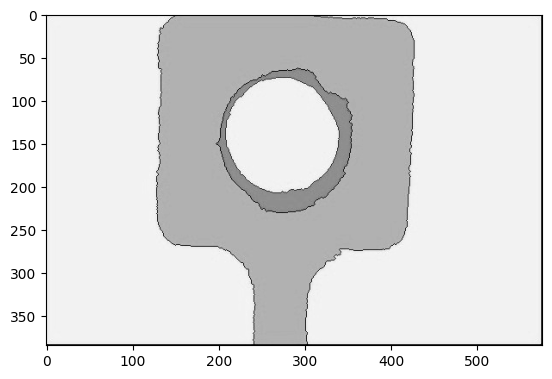

In [14]:
# file = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\\train\Outputs\img\IMG_0467_blurred.JPG"
# img = cv2.imread(file)
# plt.imshow(img)
# img.shape

file = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/03- train- Img only\Watershed Out\img\IMG_00074.jpg"
img = cv2.imread(file, 0)
print(img)
plt.imshow(img, cmap='gray')
img.shape[:]

In [15]:
seed = 42
BATCH_SIZE = 32
inputDataGen2 = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  zoom_range=0.2,
                                  fill_mode='nearest',
                                  )
#inputDataGen = ImageDataGenerator(rescale=1./255)

# inGen = inputDataGen.flow_from_directory(path + '\\01- train\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
# outGen = inputDataGen.flow_from_directory(path + '\\01- train\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
inGen = inputDataGen2.flow_from_directory(path + '\\03- train- Img only\\Input', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen2.flow_from_directory(path + '\\03- train- Img only\\Watershed Out', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')

sampleSize = inGen.samples

train_generator = zip(inGen, outGen)

Found 561 images belonging to 1 classes.
Found 561 images belonging to 1 classes.


In [16]:
# inGen = outputDataGen.flow_from_directory(path + '\\02- test\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
# outGen = outputDataGen.flow_from_directory(path + '\\02- test\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode="grayscale")
inGen = inputDataGen2.flow_from_directory(path + '\\04- test- Img only\\Input', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen2.flow_from_directory(path + '\\04- test- Img only\\Watershed Out', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode="grayscale")

test_generator = zip(inGen, outGen)

Found 186 images belonging to 1 classes.
Found 186 images belonging to 1 classes.


In [17]:
def double_conv_block(x, out_channels):
    x = layers.Conv2D(filters= out_channels, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters= out_channels, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x 

In [18]:
def downsample_block(x, out_channels):
    f = double_conv_block(x, out_channels)
    p = layers.MaxPool2D(pool_size=2, strides=2)(f)
    p = layers.Dropout(0.5)(p)
    return f, p

In [19]:
def upsample_block(x, conv_features, out_channels):
    x = layers.Conv2DTranspose(filters = out_channels, kernel_size=2, strides=2, padding='same')(x)
    x = layers.concatenate(inputs=[x, conv_features], axis=3)
    x = layers.Dropout(0.5)(x)
    x = double_conv_block(x, out_channels)
    return x

In [20]:
def build_unet_model():
    inputs = layers.Input(shape=(HEIGHT, WIDTH, 1))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = layers.MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = layers.MaxPool2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = layers.MaxPool2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = layers.MaxPool2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)

    model = tf.keras.Model(inputs, conv10)
    return model



In [21]:
unet_model = build_unet_model()
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 384, 576, 1)]        0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 384, 576, 64)         640       ['input_2[0][0]']             
                                                                                                  
 conv2d_25 (Conv2D)          (None, 384, 576, 64)         36928     ['conv2d_24[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 192, 288, 64)         0         ['conv2d_25[0][0]']           
 g2D)                                                                                       

In [22]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
acc_metric = tf.keras.metrics.BinaryAccuracy()
opt =tf.keras.optimizers.Adam(learning_rate=1e-4)
NUM_EPOCHS = 45
STEPS_PER_EPOCH = sampleSize//BATCH_SIZE

for epoch in range(NUM_EPOCHS):
  print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
  epochTime = time.time()
  
  # Train loop
  stepTime = 0
  for step in range(STEPS_PER_EPOCH):
    stepStartTime = time.time()
    print(f'Step {step+1}/{STEPS_PER_EPOCH}')
    x, y = next(train_generator)
    
    with tf.GradientTape() as tape:
      preds = unet_model(x)  
      train_loss = loss_fn(y, preds)
      train_acc = acc_metric(y, preds)
      print(f'Step {step+1} train loss: {train_loss} - train acc: {train_acc}')
    gradients = tape.gradient(train_loss, unet_model.trainable_variables)  
    opt.apply_gradients(zip(gradients, unet_model.trainable_variables))
    stepTime = stepTime + time.time() - stepStartTime
    print(stepTime)

  # Validation loop
  for x, y in test_generator:
    val_loss = loss_fn(y, unet_model(x)) 
    
  print(f'Epoch {epoch+1} train loss: {train_loss} - val loss: {val_loss}')

Epoch 1/45
Step 1/17
Step 1 train loss: 0.0 - train acc: 0.0
151.04821920394897
Step 2/17
Step 2 train loss: 0.0 - train acc: 0.0
309.6276090145111
Step 3/17
Step 3 train loss: 0.0 - train acc: 0.0


KeyboardInterrupt: 

In [23]:
testFile = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00718.JPG"
testImg = image.load_img(testFile, color_mode='grayscale')
testImg = np.expand_dims(testImg, axis=0)
testImg = testImg/255
testImg = testImg
imOut = unet_model.predict(testImg)

1/1 [==============================] - 1s 1s/step


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


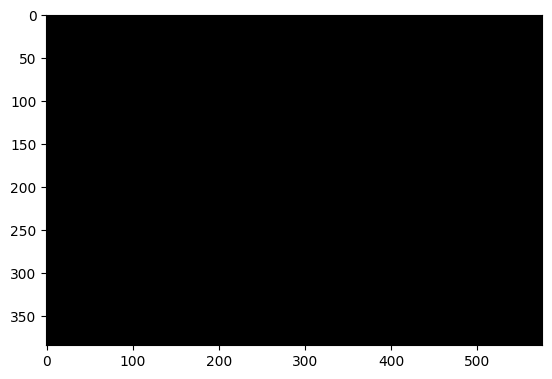

In [25]:
imOut = imOut.reshape(testImg.shape[1:3])
print(imOut)
normalizedArr = tf.keras.utils.normalize(imOut)
predicted_mask = (normalizedArr > .104).astype(np.uint32)
plt.imshow(imOut, cmap='gray')

In [ ]:
model_location = "W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\models/"
unet_model.save(model_location + '/' + 'Ring Mask- 30 Epochs- 561 img' + ".h5")

C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
